### Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/MMAFEDB/valid/neutral/8867Exp6fighting_expression_295.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8870Exp6fighting_expression_308.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8871Exp6fighting_expression_308.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8872Exp6fighting_expression_320.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8873Exp6fighting_expression_326.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8875Exp6fighting_expression_342.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8876Exp6fighting_expression_346.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8878Exp6fighting_expression_395.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8880Exp6fighting_expression_413.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8881Exp6fighting_expression_45.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8882Exp6fighting_expression_46.jpg  
  inflating: /content/MMAFEDB/valid/neutral/8887E

In [ ]:
# import all library required
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.style.use("seaborn-darkgrid")

In [ ]:
# Display progress bar
from tqdm import tqdm

In [ ]:
# list of files in train folder
files=os.listdir("/content/MMAFEDB/train")
files

['sad', 'disgust', 'surprise', 'neutral', 'happy', 'angry', 'fear']

### Data transformations and cleaning

In [ ]:
#now create image and label array
image_array=[]
label_array=[]
path="/content/MMAFEDB/train/"
# loop through each sub-folder in train
for i in range(len(files)):
    # files in sub-folder
    file_sub=os.listdir(path+files[i])

   # print(len(file_sub))
    # loop through each files

    # for neutral and happy dataset we will use only 18000 image
    if(files[i]=="neutral" or files[i]=="happy"):
        for k in tqdm(range(20000)):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block
    else:
        # for other all
        for k in tqdm(range(len(file_sub))):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block

100%|██████████| 4859/4859 [00:00<00:00, 15247.40it/s]


In [ ]:
a,b=np.unique(label_array,return_counts="True")
a

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
b
# I reduced our training dataset because of Colab RAM limitations

array([12223,  3231,  8113, 20000, 20000,  6566,  4859])

In [ ]:
# now use this to free some RAM memory
import gc
gc.collect()

352

In [ ]:
#scaling
image_array=np.array(image_array)/255.0
# convert label list to array
label_array=np.array(label_array)
# run this block

In [ ]:
print(label_array)


[0 0 0 ... 6 6 6]


## Defining label_to_text


In [ ]:
label_to_text={0:"sad",1:"disgust",2:"surprise",3:"neutral",4:"happy",5:"angry",6:"fear"}

In [ ]:
gc.collect()
from sklearn.model_selection import train_test_split
image_array,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.2)
#20% for validation
gc.collect()

0

### Dataset examples

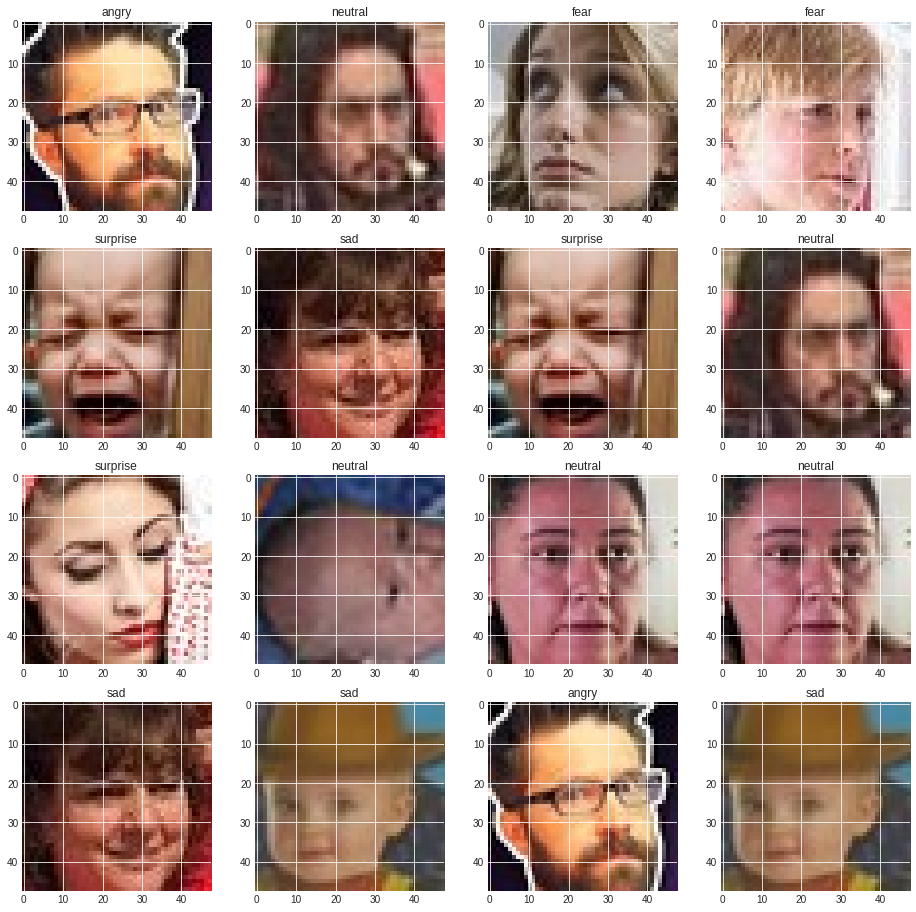

In [ ]:
def show_examples(image,label,idx):
    # create 4x4 figure
    fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(16,16))
    # loop through each figure
    for idx_f,ax in zip(idx,axes.ravel()):
        # add image to figure
        ax.imshow(image[idx_f].squeeze(),cmap="gray")
        # add title to each figure
        ax.set_title(label_to_text[label[idx_f]])
    plt.show()
idx=np.random.choice(16,16)
show_examples(image_array,Y_train,idx)

### Import libraries required by model

In [ ]:
from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential,Model,load_model
from keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
model=Sequential()
# MobileNetV2 as an pretrained model
pretrained_model=MobileNetV2(input_shape=(48,48,3),include_top=False,
                                         weights="imagenet")


pretrained_model.trainable=True
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
# add dropout to increase accuracy by not overfitting
model.add(layers.Dropout(0.3))
# add dense layer as final output
model.add(layers.Dense(1))
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/mode.png', show_shapes=True)
from tensorflow.keras.optimizers import Adam

In [ ]:
#compile model

model.compile(optimizer=Adam(0.0001),loss="mean_squared_error",metrics=["mae"])
# run
# starting learning rate is 1e-3


In [ ]:
# create a model checkpoint to save model
ckp_path="/content/"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                   monitor="val_mae",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="auto")
# this checkpoint save model when val_mae is lower then best val_mae
#run


In [ ]:

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(factor=0.9,
                                              monitor="val_mae",
                                              mode="auto",
                                              cooldown=0,
                                              patience=5,
                                              verbose=1,
                                              min_lr=1e-6)
# this will decrease learning rate when val_mae does't decrease durning last 5 epoch
# verbose is use to show val_mae every epoch


In [ ]:
EPOCHS=500
BATCH_SIZE=64
# start training
history=model.fit(image_array,Y_train,
                 validation_data=(X_test,Y_test),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint,reduce_lr])
#run

Epoch 1/500
1055/1055 [==============================] - 87s 31ms/step - loss: 4.5804 - mae: 1.7216 - val_loss: 32.8356 - val_mae: 5.3541
Epoch 2/500
1055/1055 [==============================] - 28s 27ms/step - loss: 2.8185 - mae: 1.3473 - val_loss: 3.5766 - val_mae: 1.4378
Epoch 3/500
1055/1055 [==============================] - 28s 26ms/step - loss: 2.5853 - mae: 1.2786 - val_loss: 3.0121 - val_mae: 1.3135
Epoch 4/500
1055/1055 [==============================] - 28s 26ms/step - loss: 2.3823 - mae: 1.2163 - val_loss: 2.8046 - val_mae: 1.2835
Epoch 5/500
1055/1055 [==============================] - 28s 27ms/step - loss: 2.1801 - mae: 1.1566 - val_loss: 2.7753 - val_mae: 1.3033
Epoch 6/500
1055/1055 [==============================] - 27s 26ms/step - loss: 1.9801 - mae: 1.0950 - val_loss: 2.8710 - val_mae: 1.2807
Epoch 7/500
1055/1055 [==============================] - 28s 26ms/step - loss: 1.7663 - mae: 1.0263 - val_loss: 3.0041 - val_mae: 1.2860
Epoch 8/500
1055/1055 [=================

In [ ]:
# after training is finished
# load best model
model.load_weights(ckp_path)

In [ ]:
print(prediction_val[:10])
print (type(prediction_val))

[[1.3641523]
 [0.8178886]
 [3.0498328]
 [3.96738  ]
 [2.9305284]
 [2.9834912]
 [2.9256098]
 [3.012341 ]
 [3.9315662]
 [2.827979 ]]
<class 'numpy.ndarray'>


In [ ]:
print(Y_test[:10])

[2 3 0 4 4 3 6 3 4 0]


In [ ]:
y_pred=np.round(prediction_val)
print(y_pred)

[[1.]
 [1.]
 [3.]
 ...
 [3.]
 [5.]
 [2.]]


In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(Y_test, y_pred))

0.5138666666666667


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)